In [1]:
import numpy as np
import os
import cv2
import math
from matplotlib import pyplot as plt


In [36]:

data = np.load('Fest_test.npy', allow_pickle=True).item()
print(data.keys())

q1    = data['q1']
q2    = data['q2']
#FTrue = data['Ftrue']



dict_keys(['q1', 'q2', 'Ftrue'])


In [37]:
def normalize_points(points):
    mean = np.mean(points, axis = 0) #calculates the mean column-wise
    std_dev = np.std(points)
    scale = np.sqrt(2) /std_dev
    translation = -mean * scale
    T = np.array([[scale, 0, translation[0]],
                  [0, scale, translation[1]],
                  [0,     0,              1]
                ])
    return T.dot(points).T, T



def Fest_8point(p1, p2):
    '''estimates a fundamental matrix from eight or more point correspondences, using the linear algorithm.'''
    # normalize image coordinates
    n1, T1 = normalize_points(p1)
    n2, T2 = normalize_points(p2)

    # Construct the A matrix for the linear system
    A = np.zeros((p1.shape[0], 9))
    #insert values
    for i in range(p1.shape[0]):
        A[i][0] = n1[i][0] * n2[i][0]
        A[i][1] = n1[i][0]*n2[i][1]
        A[i][2] = n1[i][0]
        A[i][3] = n1[i][1]*n2[i][0]
        A[i][4] = n1[i][1]*n2[i][1]
        A[i][5] = n1[i][1] 
        A[i][6] = n2[i][0]
        A[i][7] = n2[i][1]
        A[i][8] = 1.0  

        '''
        A[i] = [n1[i, 0] * n2[i, 0],
                n1[i, 0] * n2[i, 1],
                n1[i, 0],
                n1[i, 1] * n2[i, 0],
                n1[i, 1] * n2[i, 1],
                n1[i, 1],
                n2[i, 0],
                n2[i, 1],
                1]
'''
    # Solve linear system using least squares
    _, _, V = np.linalg.svd(A)

    f_vec = V.T[:,8]
    #F = V[-1].reshape(3, 3)
    F = np.reshape(f_vec, (3,3))

    # Enforcing rank-2 constraint on fundamental matrix
    s, v, d = np.linalg.svd(F)
    F =  s @ np.diag([*v[:2], 0]) @ d

    # Denormalizing fundamental matrix
    F = T2.T @ F @ T1

    return F / F[2, 2]
 

In [38]:
F = Fest_8point(q1, q2)

from util_functions import fundamental_matrix

data = np.load('TwoImageDataCar.npy', allow_pickle=True).item()
print(data.keys())
#compute the fundamental matrix between the two images
im1 = data['im1']
im2 = data['im2']
K = data['K']
t1, t2 = data['t1'], data['t2']
R1, R2 = data['R1'], data['R2']
FTrue = fundamental_matrix(K, R1, t1, K, R2, t2)


print(f'part 3.8 -> F: {F}')
print(f'F: {F}\n')

#They're the same!!! :))))



dict_keys(['im1', 'R1', 't1', 'im2', 'R2', 't2', 'K'])
t_tilde shape : (3, 1)
part 3.8 -> F: [[-8.93111418e-06  3.45198954e-06  1.65990832e-03]
 [ 5.42200668e-06 -1.91944250e-06 -1.28436484e-03]
 [ 7.59779597e-04 -1.02064614e-03  1.00000000e+00]]
F: [[-8.93111418e-06  3.45198954e-06  1.65990832e-03]
 [ 5.42200668e-06 -1.91944250e-06 -1.28436484e-03]
 [ 7.59779597e-04 -1.02064614e-03  1.00000000e+00]]



dict_keys(['im1', 'im2', 'R1', 'R2', 't1', 't2', 'K'])
[[17 17 14 ... 19 18 20]
 [15 16 15 ... 18 17 19]
 [14 14 15 ... 18 18 21]
 ...
 [13 14 16 ...  4  4  5]
 [13 13 14 ...  4  5  6]
 [12 13 14 ...  6  6  5]]

[[14 15 12 ... 22 20 21]
 [13 14 14 ... 21 19 20]
 [13 12 13 ... 19 20 22]
 ...
 [14 19 38 ...  5  5  6]
 [27 56 90 ...  5  6  7]
 [49 76 74 ...  5  7  6]]


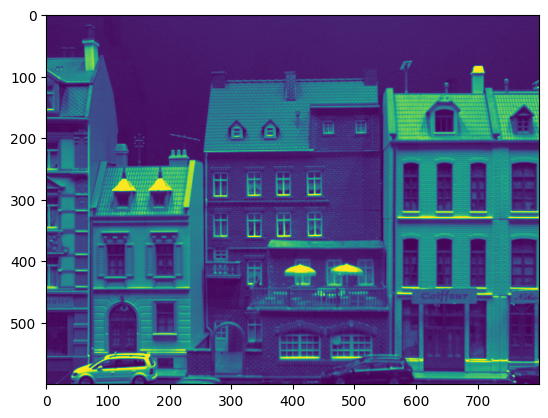

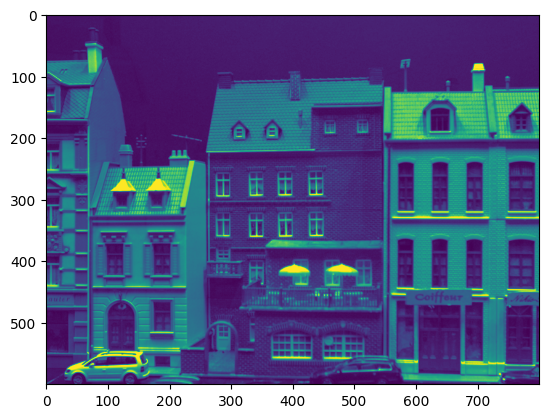

True

In [59]:
#part 9.2

im_data = np.load('TwoImageData.npy', allow_pickle=True).item()
print(im_data.keys())
#compute the fundamental matrix between the two images
data1 = im_data['im1']
print(data1)
print()
data2 = im_data['im2']
print(data2)
#convert to grayscale
im1 = np.uint8(data1)  # Convert to uint8 if necessary
im2 = np.uint8(data2)

plt.imshow(im1)
plt.show()

plt.imshow(im2)
plt.show()
# Save the image to a file using cv2.imwrite()
cv2.imwrite('im1.jpg', im1)
cv2.imwrite('im2.jpg', im2)




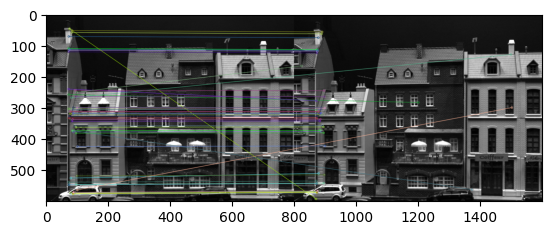

In [84]:
# Initialize SIFT detector


sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(im1, None)
keypoints2, descriptors2 = sift.detectAndCompute(im2, None)

# Initialize Brute-Force Matcher
bf = cv2.BFMatcher_create(crossCheck= True)
matches = bf.match(descriptors1, descriptors2)
#matches = sorted(matches, key=lambda x: x.distance)

matching_result = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches[200: 250], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(matching_result)
plt.show()

In [85]:
#part 9.3

rnd_matches = np.random.choice(matches, 8, replace=False)

random_keypoints1 = np.float32([keypoints1[match.queryIdx].pt for match in rnd_matches]).reshape(-1, 2)
random_keypoints2 = np.float32([keypoints2[match.trainIdx].pt for match in rnd_matches]).reshape(-1, 2)
#make the points 3d with hom coords
random_keypoints1_homogeneous = np.stack((random_keypoints1[:, 0], random_keypoints1[:, 1], np.ones(len(random_keypoints1))), axis=1)
random_keypoints2_homogeneous = np.stack((random_keypoints2[:, 0], random_keypoints2[:, 1], np.ones(len(random_keypoints2))), axis=1)

# Estimate fundamental matrix using Fest_8point function
F_estimated = Fest_8point(random_keypoints1.T, random_keypoints2.T)


ValueError: shapes (3,3) and (2,8) not aligned: 3 (dim 1) != 2 (dim 0)